# drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
default_path = "/content/drive/MyDrive/study/mini2/model_data/"

In [ ]:
df_train = pd.read_csv(default_path + "train_df.csv")
df_test = pd.read_csv(default_path + "test_df.csv")

# global variable

In [ ]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

# EDA

In [ ]:
train = df_train.copy()
test = df_test.copy()

- train set target 비율 확인

In [ ]:
# Check the proportion of the 'transfer' column in the training set
transfer_proportion = train['transfer'].value_counts(normalize=True)
display(transfer_proportion)

,proportion
transfer,
0,0.831305
1,0.168695


- type 확인

In [ ]:
train.drop("player_id", axis=1, inplace=True)
test.drop("player_id", axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14873 entries, 0 to 14872
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season                              14873 non-null  object 
 1   player_name                         14873 non-null  object 
 2   goals                               14873 non-null  int64  
 3   assists                             14873 non-null  int64  
 4   yellow_cards                        14873 non-null  int64  
 5   red_cards                           14873 non-null  int64  
 6   season_win_count                    14873 non-null  int64  
 7   season_avg_minutes                  14873 non-null  float64
 8   club_squad_size                     14873 non-null  float64
 9   club_average_age                    14873 non-null  float64
 10  club_foreigners_percentage          14873 non-null  float64
 11  club_national_team_players          14873

## 결측치 확인

In [ ]:
# df_train, df_test 결측치 있는 column 리스트 뽑기
missing_columns_train = train.columns[train.isnull().any()].tolist()
missing_columns_test = test.columns[test.isnull().any()].tolist()
missing_columns = set(missing_columns_train).union(set(missing_columns_test))
print(missing_columns)

{'height_in_cm', 'date_of_birth', 'market_value_in_eur', 'agent_name', 'foot', 'country_of_birth', 'player_highest_market_value_in_eur'}


In [ ]:
# Calculate the mean and median of the 'height_in_cm' column in the training set
mean_height = train['height_in_cm'].mean()
median_height = train['height_in_cm'].median()

print(f"Mean of 'height_in_cm': {mean_height}")
print(f"Median of 'height_in_cm': {median_height}")


Mean of 'height_in_cm': 182.62501690331305
Median of 'height_in_cm': 183.0


In [ ]:
# Median으로 결측치 제거
train['height_in_cm'].fillna(median_height, inplace=True)
test['height_in_cm'].fillna(median_height, inplace=True)

/tmp/ipython-input-1980408521.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['height_in_cm'].fillna(median_height, inplace=True)
/tmp/ipython-input-1980408521.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [ ]:
# date_of_birth 확인
train['date_of_birth'].sample(5)

,date_of_birth
9679,1993-03-10 00:00:00
1988,1983-03-07 00:00:00
5370,1991-06-25 00:00:00
3189,1988-01-03 00:00:00
3219,1987-10-07 00:00:00


In [ ]:
import pandas as pd
from datetime import datetime

# date_of_birth 컬럼을 datetime으로 변환
train["date_of_birth"] = pd.to_datetime(train["date_of_birth"], errors="coerce")
test["date_of_birth"] = pd.to_datetime(test["date_of_birth"], errors="coerce")

# Extract the year from the 'season' column
train['season_year'] = train['season'].str.split('/').str[0].astype(int) + 2000
test['season_year'] = test['season'].str.split('/').str[0].astype(int) + 2000

# Calculate age using the season year
train["age"] = train["season_year"] - train["date_of_birth"].dt.year
test["age"] = test["season_year"] - test["date_of_birth"].dt.year

# Drop the temporary 'season_year' column
train = train.drop('season_year', axis=1)
test = test.drop('season_year', axis=1)

print(train[["date_of_birth", "age", 'season']].head())

  date_of_birth   age season
0    1979-11-08  33.0  12/13
1    1987-04-16  25.0  12/13
2    1990-12-26  22.0  12/13
3    1992-11-11  20.0  12/13
4    1986-05-11  26.0  12/13


In [ ]:
# date_of_birth 제거
train.drop('date_of_birth', axis=1, inplace=True)
test.drop('date_of_birth', axis=1, inplace=True)

In [ ]:
age_median = train['age'].median()
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)

/tmp/ipython-input-833419169.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_median, inplace=True)
/tmp/ipython-input-833419169.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
train['market_value_in_eur'].isnull().sum()

np.int64(165)

In [ ]:
# Fill missing market_value_in_eur using the average market value for each player
train['market_value_in_eur'] = train.groupby('player_name')['market_value_in_eur'].transform(lambda x: x.fillna(x.mean()))

# Verify if there are any remaining missing values in 'market_value_in_eur'
display(train['market_value_in_eur'].isnull().sum())

np.int64(89)

In [ ]:
median_market = train['market_value_in_eur'].median()
train['market_value_in_eur'].fillna(median_market, inplace=True)

/tmp/ipython-input-2164618017.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['market_value_in_eur'].fillna(median_market, inplace=True)


In [ ]:
# Calculate the average market value for each player in the TRAINING set
average_market_value_train = train.groupby('player_name')['market_value_in_eur'].mean()

# Fill missing market_value_in_eur in the TEST set using the average market value from the TRAINING set
# Use map to apply the average from the training set to the test set based on player name
test['market_value_in_eur'] = df_test.apply(
    lambda row: average_market_value_train.get(row['player_name'], row['market_value_in_eur']) if pd.isnull(row['market_value_in_eur']) else row['market_value_in_eur'],
    axis=1
)

# For players in the test set who were NOT in the training set and still have missing market values,
# fill with the overall median market value from the training set.
test['market_value_in_eur'].fillna(median_market, inplace=True)


# Verify if there are any remaining missing values in 'market_value_in_eur' in the test set
display(test['market_value_in_eur'].isnull().sum())

/tmp/ipython-input-2982186875.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['market_value_in_eur'].fillna(median_market, inplace=True)


np.int64(0)

In [ ]:
train['agent_name'].value_counts()

,count
agent_name,
CAA Stellar,1115
Wasserman,1017
Unique Sports Group,754
CAA Base Ltd,598
ROOF,346
...,...
Jason N. Pappe,1
UNOSPORTS,1
Jozef Tokos,1


In [ ]:
train['agent_name'].fillna('Unknown', inplace=True)
test['agent_name'].fillna('Unknown', inplace=True)
train['agent_name'].isnull().sum()

/tmp/ipython-input-2100854652.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['agent_name'].fillna('Unknown', inplace=True)
/tmp/ipython-input-2100854652.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

np.int64(0)

In [ ]:
mode_foot = train['foot'].mode()[0]
mode_foot

'right'

In [ ]:
train['foot'].fillna(mode_foot, inplace=True)
test['foot'].fillna(mode_foot, inplace=True)

/tmp/ipython-input-2988022274.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['foot'].fillna(mode_foot, inplace=True)
/tmp/ipython-input-2988022274.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
# Fill missing 'country_of_birth' values with 'Unknown'
train['country_of_birth'].fillna('Unknown', inplace=True)
test['country_of_birth'].fillna('Unknown', inplace=True)

# Verify if there are any remaining missing values in 'country_of_birth'
display(train['country_of_birth'].isnull().sum())
display(test['country_of_birth'].isnull().sum())

/tmp/ipython-input-2802813172.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['country_of_birth'].fillna('Unknown', inplace=True)
/tmp/ipython-input-2802813172.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

np.int64(0)

np.int64(0)

In [ ]:
highest_market = train['player_highest_market_value_in_eur'].median()
train['player_highest_market_value_in_eur'].fillna(highest_market, inplace=True)
test['player_highest_market_value_in_eur'].fillna(highest_market, inplace=True)

/tmp/ipython-input-1794034737.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['player_highest_market_value_in_eur'].fillna(highest_market, inplace=True)
/tmp/ipython-input-1794034737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(np.int64(0), np.int64(0))

# feature Engineearing

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14873 entries, 0 to 14872
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season                              14873 non-null  object 
 1   player_name                         14873 non-null  object 
 2   goals                               14873 non-null  int64  
 3   assists                             14873 non-null  int64  
 4   yellow_cards                        14873 non-null  int64  
 5   red_cards                           14873 non-null  int64  
 6   season_win_count                    14873 non-null  int64  
 7   season_avg_minutes                  14873 non-null  float64
 8   club_squad_size                     14873 non-null  float64
 9   club_average_age                    14873 non-null  float64
 10  club_foreigners_percentage          14873 non-null  float64
 11  club_national_team_players          14873

- 필요없는 columns 제거

In [ ]:
# player_name 제거
train.drop("player_name", axis=1, inplace=True)
test.drop("player_name", axis=1, inplace=True)

In [ ]:
# position
train['position'].value_counts()
train.groupby('position')['transfer'].mean()

,transfer
position,
Attack,0.205412
Defender,0.142264
Goalkeeper,0.165225
Midfield,0.164548


In [ ]:
# position이 attack이고, goal에 따른 transfer 비율 비교하기
attack_players = train[train['position'] == 'Midfield']
attack_players.groupby('goals')['transfer'].mean()

,transfer
goals,
0,0.210043
1,0.152381
2,0.117647
3,0.133117
4,0.129187
5,0.134969
6,0.055556
7,0.091837
8,0.105263


In [ ]:
# country_of_birth 이진 인코딩
train['country_england'] = train['country_of_birth'].apply(lambda x: 1 if x.lower() == 'england' else 0)
test['country_england'] = test['country_of_birth'].apply(lambda x: 1 if x.lower() == 'england' else 0)

In [ ]:
drop_cols = ["agent_name", "net_transfer_record", "country_of_birth"]

# 컬럼 삭제
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [ ]:
train.shape, test.shape

((14873, 23), (1442, 23))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14873 entries, 0 to 14872
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season                              14873 non-null  object 
 1   goals                               14873 non-null  int64  
 2   assists                             14873 non-null  int64  
 3   yellow_cards                        14873 non-null  int64  
 4   red_cards                           14873 non-null  int64  
 5   season_win_count                    14873 non-null  int64  
 6   season_avg_minutes                  14873 non-null  float64
 7   club_squad_size                     14873 non-null  float64
 8   club_average_age                    14873 non-null  float64
 9   club_foreigners_percentage          14873 non-null  float64
 10  club_national_team_players          14873 non-null  float64
 11  player_highest_market_value_in_eur  14873

In [ ]:
train['foot'] = train['foot'].apply(lambda x: 1 if x.lower() == 'right' else 0)
test['foot'] = test['foot'].apply(lambda x: 1 if x.lower() == 'right' else 0)

In [ ]:
# season_last_club_position 구간화
def season_last_club_position_bin(row):
    if row['season_last_club_position'] < 5:
        return 'low'
    elif row['season_last_club_position'] < 8:
        return 'middle'
    elif row['season_last_club_position'] < 18:
        return 'high'
    else:
        return 'very high'

In [ ]:
train['season_last_club_position_bin'] = train.apply(season_last_club_position_bin, axis=1)
test['season_last_club_position_bin'] = test.apply(season_last_club_position_bin, axis=1)

In [ ]:
train.drop('season_last_club_position', axis=1, inplace=True)
test.drop('season_last_club_position', axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14873 entries, 0 to 14872
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season                              14873 non-null  object 
 1   goals                               14873 non-null  int64  
 2   assists                             14873 non-null  int64  
 3   yellow_cards                        14873 non-null  int64  
 4   red_cards                           14873 non-null  int64  
 5   season_win_count                    14873 non-null  int64  
 6   season_avg_minutes                  14873 non-null  float64
 7   club_squad_size                     14873 non-null  float64
 8   club_average_age                    14873 non-null  float64
 9   club_foreigners_percentage          14873 non-null  float64
 10  club_national_team_players          14873 non-null  float64
 11  player_highest_market_value_in_eur  14873

In [ ]:
import pandas as pd

# 3️⃣ player_age vs club_average_age
train["age_diff_club"] = train["age"] - train["club_average_age"]
test["age_diff_club"] = test["age"] - test["club_average_age"]

train["age_ratio_club"] = train["age"] / (train["club_average_age"] + 1e-6)  # 0 나눗셈 방지
test["age_ratio_club"] = test["age"] / (test["club_average_age"] + 1e-6)  # 0 나눗셈 방지

# 4️⃣ (goals + assists) vs season_win_count
train["goal_assist"] = train["goals"] + train["assists"]
test["goal_assist"] = test["goals"] + test["assists"]

train["goal_assist_win_ratio"] = train["goal_assist"] / (train["season_win_count"] + 1)  # 0회 방지
test["goal_assist_win_ratio"] = test["goal_assist"] / (test["season_win_count"] + 1)  # 0회 방지

# 확인
print(train[[
    "age", "club_average_age", "age_diff_club", "age_ratio_club",
    "goals", "assists", "season_win_count", "goal_assist", "goal_assist_win_ratio",
    "yellow_cards", "season_avg_minutes"
]].head())

train.info()

    age  club_average_age  age_diff_club  age_ratio_club  goals  assists  \
0  33.0              28.3            4.7        1.166078      0        0   
1  25.0              25.5           -0.5        0.980392      4        8   
2  22.0              26.8           -4.8        0.820895      1        4   
3  20.0              26.7           -6.7        0.749064      0        0   
4  26.0              26.8           -0.8        0.970149      0        0   

   season_win_count  goal_assist  goal_assist_win_ratio  yellow_cards  \
0                 6            0               0.000000             1   
1                20           12               0.571429             1   
2                20            5               0.238095             5   
3                 3            0               0.000000             0   
4                 5            0               0.000000             1   

   season_avg_minutes  
0           88.125000  
1           83.441176  
2           57.944444  
3       

In [ ]:
train.groupby(['position', 'sub_position'])['transfer'].mean()

position    sub_position      
Attack      Centre-Forward        0.193969
            Left Winger           0.223865
            Right Winger          0.211501
            Second Striker        0.236364
Defender    Centre-Back           0.143059
            Left-Back             0.143600
            Right-Back            0.139480
Goalkeeper  Goalkeeper            0.165225
Midfield    Attacking Midfield    0.150115
            Central Midfield      0.159170
            Defensive Midfield    0.184149
            Left Midfield         0.064748
            Right Midfield        0.296703
Name: transfer, dtype: float64

In [ ]:
train['detailed_position'] = train['position'] + '_' + train['sub_position']
test['detailed_position'] = test['position'] + '_' + test['sub_position']

In [ ]:
train['player_win_ratio'] = train['season_win_count'] / train['season_player_played']
test['player_win_ratio'] = test['season_win_count'] / test['season_player_played']

## 상관관계 확인

,goals,assists,yellow_cards,red_cards,season_win_count,season_avg_minutes,club_squad_size,club_average_age,club_foreigners_percentage,club_national_team_players,foot,height_in_cm,market_value_in_eur,transfer,age,country_england
goals,1.000000,0.586407,0.198430,0.032157,0.463360,0.191025,0.010481,0.002533,0.064354,0.135217,0.011228,-0.088088,0.496131,-0.053640,-0.001672,-0.009943
assists,0.586407,1.000000,0.258208,0.023519,0.529179,0.233390,0.004989,0.000807,0.076092,0.165643,-0.070503,-0.237995,0.470378,-0.069018,-0.022414,-0.020037
yellow_cards,0.198430,0.258208,1.000000,0.107369,0.401899,0.439096,0.010995,-0.002893,-0.011280,-0.021064,0.011949,-0.004477,0.195632,-0.087542,0.083481,0.000200
red_cards,0.032157,0.023519,0.107369,1.000000,0.072644,0.096473,0.008342,0.001931,-0.011600,-0.013513,0.020020,0.041841,0.026279,-0.038054,0.048361,-0.009195
season_win_count,0.463360,0.529179,0.401899,0.072644,1.000000,0.412797,0.042654,-0.004914,0.190601,0.409586,-0.021745,-0.015241,0.586382,-0.121042,0.067033,-0.064890
season_avg_minutes,0.191025,0.233390,0.439096,0.096473,0.412797,1.000000,0.000605,-0.000802,-0.017690,-0.015289,-0.012843,0.227469,0.213772,-0.153450,0.250021,-0.018063
club_squad_size,0.010481,0.004989,0.010995,0.008342,0.042654,0.000605,1.000000,-0.305866,0.018277,0.038360,0.016842,0.011935,0.070318,0.049157,-0.033666,-0.050158
club_average_age,0.002533,0.000807,-0.002893,0.001931,-0.004914,-0.000802,-0.305866,1.000000,-0.029630,0.143589,-0.002061,0.003599,-0.033163,-0.030612,0.045225,-0.005207
club_foreigners_percentage,0.064354,0.076092,-0.011280,-0.011600,0.190601,-0.017690,0.018277,-0.029630,1.000000,0.534972,-0.008482,-0.067595,0.194353,0.048289,-0.074553,-0.084878
club_national_team_players,0.135217,0.165643,-0.021064,-0.013513,0.409586,-0.015289,0.038360,0.143589,0.534972,1.000000,-0.026299,-0.060044,0.422900,0.040621,-0.105382,-0.093023


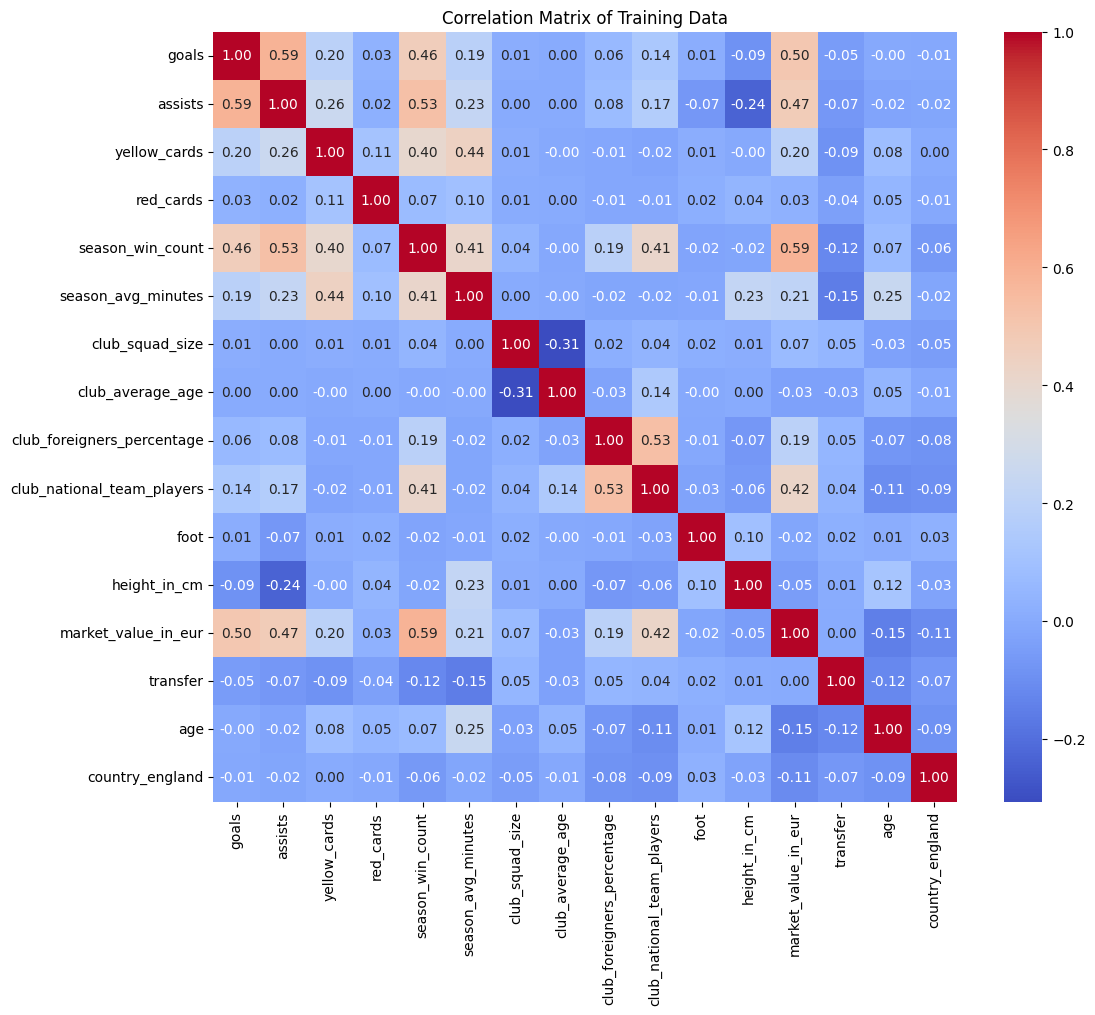

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train.corr(numeric_only=True)

# Display the correlation matrix
display(correlation_matrix)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Training Data')
plt.show()

In [ ]:
train['season_player_played_bin']= pd.qcut(train['season_player_played'], q=4, labels=['Many', 'Middle', 'Small', 'Very Small'])
test['season_player_played_bin']= pd.qcut(test['season_player_played'], q=4, labels=['Many', 'Middle', 'Small', 'Very Small'])
train.drop('season_player_played', axis=1, inplace=True)
test.drop('season_player_played', axis=1, inplace=True)

In [ ]:
train.drop(['goal_assist_win_ratio'], axis=1, inplace=True)
test.drop(['goal_assist_win_ratio'], axis=1, inplace=True)

In [ ]:
drop_col = ['player_highest_market_value_in_eur']
train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)

In [ ]:
# player_highest_market_value_in_eur 범주화 구간으로 바꾸기
train['player_highest_market_value_in_eur_bin'] = pd.qcut(train['player_highest_market_value_in_eur'], q=4, labels=['Very Hight', 'High', 'Medium', 'Low'])
test['player_highest_market_value_in_eur_bin'] = pd.qcut(test['player_highest_market_value_in_eur'], q=4, labels=['Very Hight', 'High', 'Medium', 'Low'])

In [ ]:
# 상관관계 높은 column 제거
drop_col = ['age_diff_club', 'age_ratio_club','goal_assist', 'goal_assist']
train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)

In [ ]:
train.shape, test.shape

((14873, 24), (1442, 24))

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(np.int64(0), np.int64(0))

# split_train_test

In [ ]:
reset_seeds()
from sklearn.model_selection import train_test_split

# X: 독립변수(특징 데이터프레임), y: 종속변수(타겟)
X = train.drop("transfer", axis=1)  # target 컬럼 제외
y = train["transfer"]

# test 분리
te_feature ,te_target = test.drop('transfer', axis=1), test['transfer']

# train: 80%, test: 20% (stratify로 클래스 비율 유지)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_valid.shape, y_valid.shape)

Train shape: (11898, 23) (11898,)
Test shape: (2975, 23) (2975,)


# Encoding

## label Encoding <- 노우

In [ ]:
def label_encoding(train:pd.DataFrame,test:pd.DataFrame):
  reset_seeds()
  enc_cols = train.select_dtypes(exclude=np.number).columns.tolist()
  non_enc_cols = list(set(train.columns) - set(enc_cols))
  le = LabelEncoder()
  # encoding 결과 저장할 dataframe 선언
  enco_tr = pd.DataFrame()
  enco_te = pd.DataFrame()
  for col in enc_cols:
        enco_tr[col] = le.fit_transform(train[col])
        enco_te[col] = le.fit_transform(test[col])
  # Encoding 안한거랑 합치기
  train = pd.concat([train[non_enc_cols],enco_tr], axis=1)
  test = pd.concat([ test[non_enc_cols], enco_te], axis=1)
  return train, test

In [ ]:
reset_seeds()
enco_train, enco_test = label_encoding(train, test)

In [ ]:
enco_train.shape, enco_test.shape

((14873, 24), (1442, 24))

In [ ]:
reset_seeds()
from sklearn.model_selection import train_test_split

# X: 독립변수(특징 데이터프레임), y: 종속변수(타겟)
X = enco_train.drop("transfer", axis=1)  # target 컬럼 제외
y = enco_train["transfer"]

# test 분리
te_feature ,te_target = enco_test.drop('transfer', axis=1), enco_test['transfer']

# train: 80%, test: 20% (stratify로 클래스 비율 유지)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_valid.shape, y_valid.shape)

Train shape: (11898, 25) (11898,)
Test shape: (2975, 25) (2975,)


## one hot Encoding

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
def one_hot_encoding(train:pd.DataFrame, valid:pd.DataFrame, test:pd.DataFrame):
    reset_seeds()
    enc_cols = train.select_dtypes(exclude=np.number).columns.tolist()
    non_enc_cols = list(set(valid.columns) - set(enc_cols))

    encoder = ce.OneHotEncoder(use_cat_names=True) # 인코더 생성
    encoder.fit(train[enc_cols]) # 범주형 데이터 변환 학습

    # Encoding
    train_onehot = encoder.transform(train[enc_cols])
    valid_onehot = encoder.transform(valid[enc_cols])
    test_onehot = encoder.transform(test[enc_cols])

    # Encoding 안한거랑 합치기
    train = pd.concat([train[non_enc_cols],train_onehot], axis=1)
    valid = pd.concat([valid[non_enc_cols],valid_onehot], axis=1)
    test = pd.concat([ test[non_enc_cols],test_onehot], axis=1)

    return train, valid, test

In [ ]:
reset_seeds()
enco_train, enco_valid, enco_test = one_hot_encoding(X_train, X_valid, te_feature)

In [ ]:
enco_train.shape,enco_valid.shape, enco_test.shape

((11898, 105), (2975, 105), (1442, 105))

# model

## xboost

In [ ]:
enco_train.shape, y_train.shape

((11898, 105), (11898,))

In [ ]:
reset_seeds()
from xgboost import XGBClassifier, plot_importance
model = XGBClassifier()

In [ ]:
reset_seeds()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.fit(enco_train,y_train)
pred_tr = model.predict(enco_train)
pred_vl = model.predict(enco_valid)
pred_te = model.predict(enco_test)
f1_train = f1_score(y_train, pred_tr, average='binary')
f1_valid = f1_score(y_valid, pred_vl, average='binary')
f1_test = f1_score(te_target, pred_te, average='binary')
print(f'훈련용 평가지표: {f1_train} / 테스트용 평가지표: {f1_valid}')
print(f'실제 평가지표: {f1_test}')

훈련용 평가지표: 0.9518605256310174 / 테스트용 평가지표: 0.8181818181818182
실제 평가지표: 0.8929889298892989


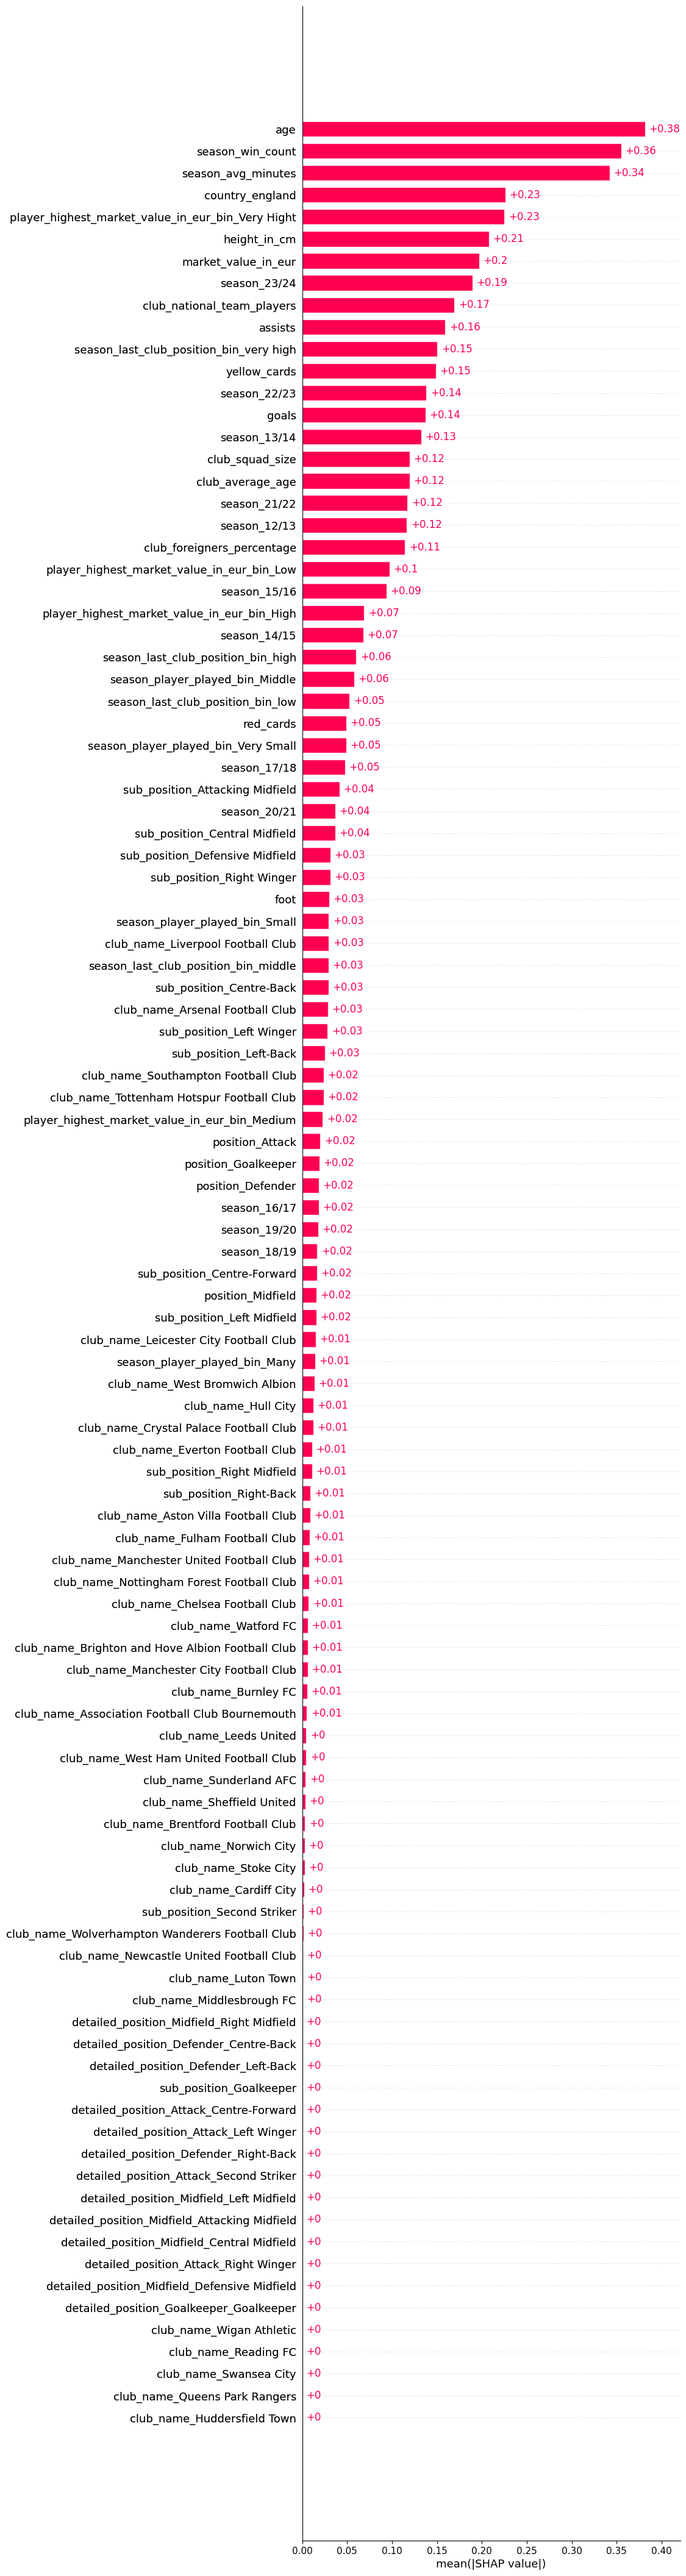

In [ ]:
# sharp 확인하자
import shap
reset_seeds()
explainer = shap.Explainer(model)
shap_values = explainer(enco_valid)
shap.plots.bar(shap_values, max_display=enco_valid.shape[0])

# player_highest_market_value_in_eur, sason_avg_minutes, season, country_of_brith_England, market_value_in_eur_height_in_cm, goals, player_played, club_suqad_size

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# 1. Train/Test 분리
# -----------------------------
X = df.drop("transfer", axis=1)
y = df["transfer"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------------
# 2. 불균형 처리 - scale_pos_weight
# -----------------------------
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos

# -----------------------------
# 3. XGBoost 학습
# -----------------------------
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# -----------------------------
# 4. 평가 함수
# -----------------------------
def print_metrics(y_true, y_pred, name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# -----------------------------
# 5. Train / Test 평가
# -----------------------------
datasets = {
    'Train': (X_train, y_train),
    'Test': (X_test, y_test)
}

for name, (X_set, y_set) in datasets.items():
    y_pred = model.predict(X_set)
    print_metrics(y_set, y_pred, name)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:player_name: object

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# 1. XGBoost 학습 (train 데이터)
# -----------------------------
# X_train, y_train은 이미 준비된 상태
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# -----------------------------
# 2. Valid 데이터 준비
# -----------------------------
X_valid = df_validation.drop("transfer", axis=1)
y_valid = df_validation["transfer"]

# -----------------------------
# 3. 평가 함수
# -----------------------------
def print_metrics(y_true, y_pred, name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# -----------------------------
# 4. Valid 데이터만 평가
# -----------------------------
y_valid_pred = model.predict(X_valid)
print_metrics(y_valid, y_valid_pred, "Valid")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:21:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Valid -> Accuracy: 0.7816, Precision: 0.8908, Recall: 0.3212, F1-score: 0.4722


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# 1. Train/Test 분리
# -----------------------------
X = df.drop("transfer", axis=1)
y = df["transfer"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------------
# 2. 불균형 처리 - class_weight
# -----------------------------
# LogisticRegression에서는 scale_pos_weight 대신 class_weight='balanced' 사용 가능
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

# -----------------------------
# 3. 모델 학습
# -----------------------------
model.fit(X_train, y_train)

# -----------------------------
# 4. 평가 함수
# -----------------------------
def print_metrics(y_true, y_pred, name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# -----------------------------
# 5. Train / Test 평가
# -----------------------------
datasets = {
    'Train': (X_train, y_train),
    'Test': (X_test, y_test)
}

for name, (X_set, y_set) in datasets.items():
    y_pred = model.predict(X_set)
    print_metrics(y_set, y_pred, name)

Train -> Accuracy: 0.6441, Precision: 0.2931, Recall: 0.6340, F1-score: 0.4008
Test -> Accuracy: 0.6250, Precision: 0.2793, Recall: 0.6313, F1-score: 0.3873


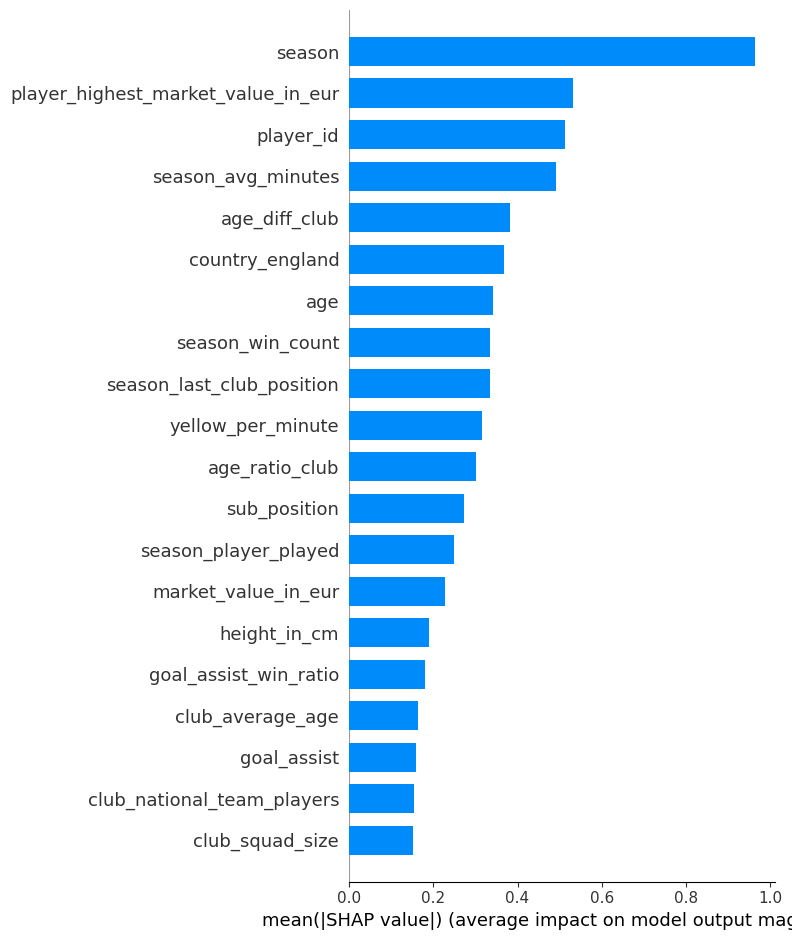

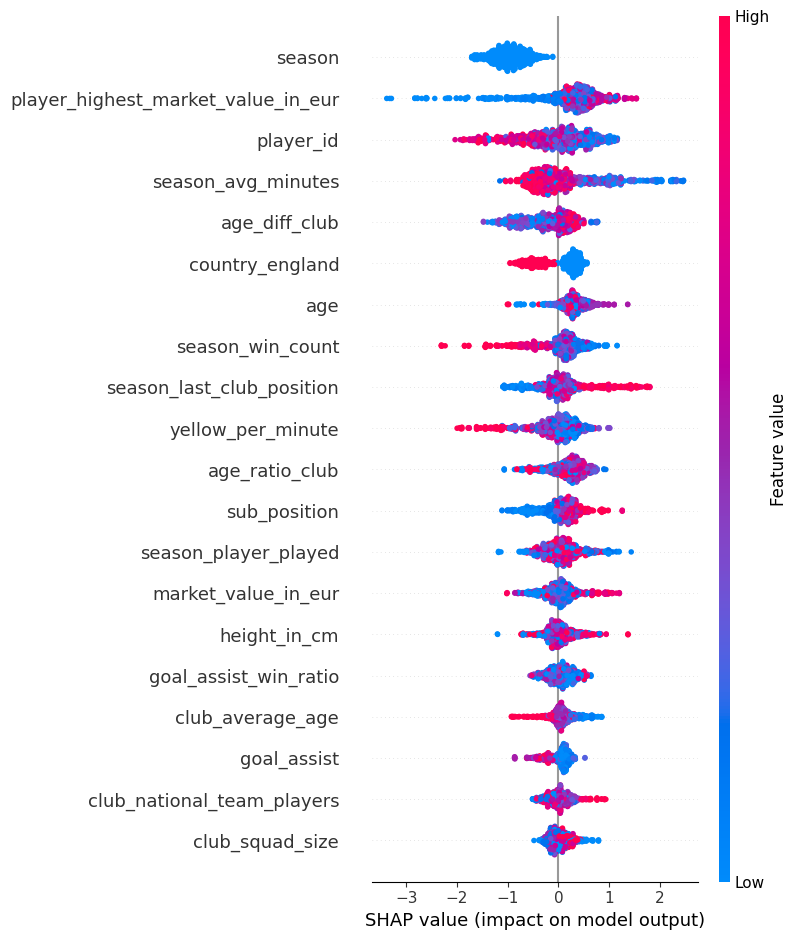

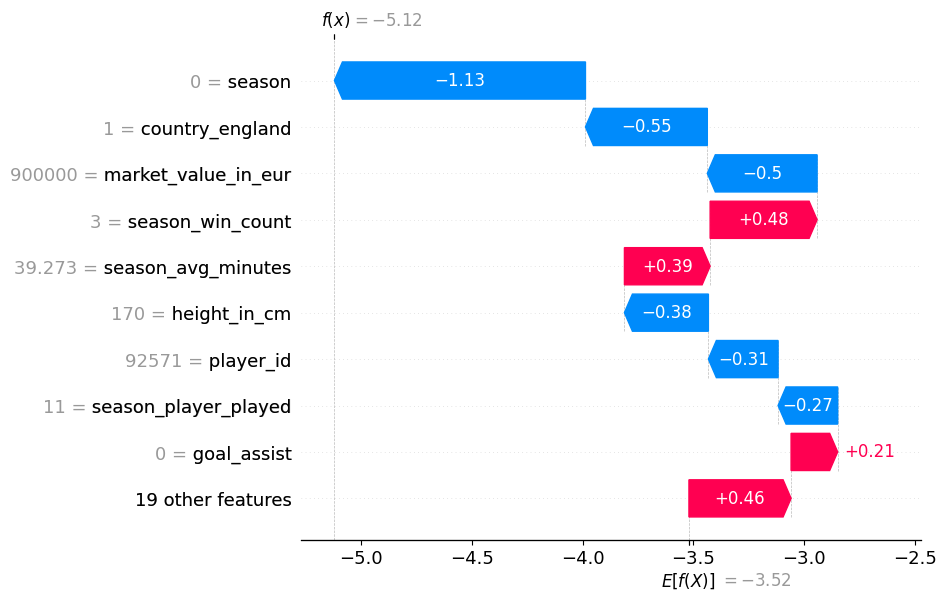

In [ ]:
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1. SHAP Explainer 생성
# -----------------------------
explainer = shap.Explainer(model, X_train)  # XGBoost 모델과 train 데이터
shap_values = explainer(X_valid)           # valid 데이터 기준 SHAP 값 계산

# -----------------------------
# 2. Feature importance summary plot
# -----------------------------
shap.summary_plot(shap_values, X_valid, plot_type="bar")  # 중요도 막대 그래프
shap.summary_plot(shap_values, X_valid)                   # 전체 SHAP 값 점 그래프

# -----------------------------
# 3. 개별 피처 영향 확인 (선택)
# -----------------------------
# 예: 첫 번째 샘플에 대한 SHAP 값
shap.plots.waterfall(shap_values[0])


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------
# 1. DMatrix 생성
# -----------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(df_validation.drop("transfer", axis=1), label=df_validation["transfer"])

# -----------------------------
# 2. 파라미터 설정
# -----------------------------
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# -----------------------------
# 3. 학습 (early stopping 적용)
# -----------------------------
evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# -----------------------------
# 4. Valid 예측
# -----------------------------
y_valid_pred = bst.predict(dvalid)
y_valid_pred_label = (y_valid_pred > 0.5).astype(int)

# -----------------------------
# 5. Valid 평가
# -----------------------------
y_valid_true = df_validation["transfer"]

acc = accuracy_score(y_valid_true, y_valid_pred_label)
prec = precision_score(y_valid_true, y_valid_pred_label)
rec = recall_score(y_valid_true, y_valid_pred_label)
f1 = f1_score(y_valid_true, y_valid_pred_label)

print(f"Valid -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")


[0]	train-logloss:0.67034	valid-logloss:0.68723
[1]	train-logloss:0.65079	valid-logloss:0.68055
[2]	train-logloss:0.63311	valid-logloss:0.67624
[3]	train-logloss:0.61923	valid-logloss:0.67079
[4]	train-logloss:0.60745	valid-logloss:0.66754
[5]	train-logloss:0.59675	valid-logloss:0.66590
[6]	train-logloss:0.58653	valid-logloss:0.65800
[7]	train-logloss:0.57706	valid-logloss:0.65665
[8]	train-logloss:0.56786	valid-logloss:0.65423
[9]	train-logloss:0.56082	valid-logloss:0.65022
[10]	train-logloss:0.55318	valid-logloss:0.64652
[11]	train-logloss:0.54621	valid-logloss:0.64489
[12]	train-logloss:0.53924	valid-logloss:0.64879
[13]	train-logloss:0.53161	valid-logloss:0.64792
[14]	train-logloss:0.52610	valid-logloss:0.64399
[15]	train-logloss:0.51989	valid-logloss:0.63788
[16]	train-logloss:0.51491	valid-logloss:0.63279
[17]	train-logloss:0.50952	valid-logloss:0.62523
[18]	train-logloss:0.50296	valid-logloss:0.62337
[19]	train-logloss:0.49797	valid-logloss:0.62117
[20]	train-logloss:0.49428	val

In [ ]:
# -----------------------------
# 1. 라이브러리 불러오기
# -----------------------------
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# -----------------------------
# 2. Train/Test 분리 (이미 8,000개 데이터)
# -----------------------------
# X_train, X_test, y_train, y_test는 이미 준비된 상태라고 가정

# -----------------------------
# 3. SMOTE 오버샘플링 적용
# -----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE :", pd.Series(y_train_res).value_counts())

# -----------------------------
# 4. XGBoost 모델 정의
# -----------------------------
pos = sum(y_train_res == 1)
neg = sum(y_train_res == 0)
scale_pos_weight = neg / pos  # SMOTE 적용 후에도 ratio 확인

model = XGBClassifier(
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

# -----------------------------
# 5. 모델 학습 (train/test 평가용)
# -----------------------------
# train으로 학습 후 test 평가
model.fit(X_train_res, y_train_res)

def print_metrics(y_true, y_pred, name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name} -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# -----------------------------
# 6. Train / Test 평가
# -----------------------------
y_train_pred = model.predict(X_train_res)
y_test_pred = model.predict(X_test)

print_metrics(y_train_res, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")

# -----------------------------
# 7. Valid 데이터 평가
# -----------------------------
X_valid = df_validation.drop("transfer", axis=1)
y_valid = df_validation["transfer"]

y_valid_pred = model.predict(X_valid)
print_metrics(y_valid, y_valid_pred, "Valid")


Before SMOTE: transfer
0    6522
1    1508
Name: count, dtype: int64
After SMOTE : transfer
1    6522
0    6522
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:14:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train -> Accuracy: 0.9980, Precision: 0.9994, Recall: 0.9966, F1-score: 0.9980
Test -> Accuracy: 0.9626, Precision: 0.9364, Recall: 0.8594, F1-score: 0.8963
Valid -> Accuracy: 0.8406, Precision: 1.0000, Recall: 0.4758, F1-score: 0.6448


In [ ]:
# -----------------------------
# 1. Valid 데이터 준비
# -----------------------------
X_valid = df_validation.drop("transfer", axis=1)
y_valid = df_validation["transfer"]

# -----------------------------
# 2. 예측 수행
# -----------------------------
y_valid_pred = model.predict(X_valid)
y_valid_proba = model.predict_proba(X_valid)[:, 1]  # transfer=1 확률값

# -----------------------------
# 3. 결과 DataFrame 생성
# -----------------------------
df_valid_result = df_validation.copy()
df_valid_result["pred_transfer"] = y_valid_pred
df_valid_result["pred_proba"] = y_valid_proba

# -----------------------------
# 4. CSV 저장
# -----------------------------
df_valid_result.to_csv("valid_predictions.csv", index=False)

print("✅ valid 예측 결과가 'valid_predictions.csv'로 저장되었습니다.")

✅ valid 예측 결과가 'valid_predictions.csv'로 저장되었습니다.


In [ ]:
average_market_value.isnull().sum()

np.int64(0)

In [ ]:
# Fill missing market_value_in_eur using the average market value for each player
df_train['market_value_in_eur'] = df_train.groupby('player_name')['market_value_in_eur'].transform(lambda x: x.fillna(x.mean()))

# Verify if there are any remaining missing values in 'market_value_in_eur'
display(df_train['market_value_in_eur'].isnull().sum())

np.int64(0)